
Step 1: Setting Up Dependencies and Model

In [103]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [104]:
import json
from typing import List, Dict, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
import asyncio
from datetime import datetime
from typing import Annotated ,List
# Initialize the language model
travel_planner_llm = ChatGroq(model="gemma2-9b-it")

travel_planner_llm.invoke("hey!")

AIMessage(content='Hey there! 👋  What can I do for you today?\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 11, 'total_tokens': 27, 'completion_time': 0.029090909, 'prompt_time': 0.00117287, 'queue_time': 0.251841176, 'total_time': 0.030263779}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--9edbeb33-06cc-4ff5-a770-83b9d2b9bd53-0', usage_metadata={'input_tokens': 11, 'output_tokens': 16, 'total_tokens': 27})

Step 2. Defining Task Structure with Pydantic Models

In [105]:
# Define the task structure for dynamic delegation
class TravelTask(BaseModel):
    """Structure for individual travel planning tasks"""
    task_id: str = Field(description="Unique identifier for the task")
    task_type: str = Field(description="Type of travel planning task")
    task_description: str = Field(description="Detailed description of what needs to be done")
    priority: int = Field(description="Task priority (1-5, where 5 is highest)")
    required_context: List[str] = Field(description="Context needed from original request")

class TaskPlan(BaseModel):
    """Complete task breakdown from orchestrator"""
    tasks: List[TravelTask] = Field(description="List of travel planning tasks")
    estimated_duration: str = Field(description="Estimated time to complete all tasks")
    special_requirements: List[str] = Field(description="Any special considerations")

# Create structured orchestrator
task_orchestrator = travel_planner_llm.with_structured_output(TaskPlan)

Step 3 Implementing State Reducer Functions

In [106]:
# Define reducer functions for concurrent updates
def merge_worker_results(current: Dict[str, str], new: Dict[str, str]) -> Dict[str, str]:
    """Merge worker results from multiple concurrent workers"""
    if current is None:
        current = {}
    current.update(new)
    return current

def merge_execution_metadata(current: Dict[str, Any], new: Dict[str, Any]) -> Dict[str, Any]:
    """Merge execution metadata from multiple concurrent workers"""
    if current is None:
        current = {}
    
    # Merge workers_executed lists
    current_workers = current.get('workers_executed', [])
    new_workers = new.get('workers_executed', [])
    
    merged_metadata = current.copy()
    merged_metadata.update(new)
    
    # Combine worker lists without duplicates
    all_workers = list(set(current_workers + new_workers))
    merged_metadata['workers_executed'] = all_workers
    
    return merged_metadata

Step 4: Defining the Workflow State Schema

In [107]:
# Define workflow state with proper annotations for concurrent updates
class TravelPlanningState(TypedDict):
    original_request: str                                      # User's travel request
    task_breakdown: Dict[str, Any]                            # Orchestrator's task analysis
    accommodation_result: str                                 # Accommodation worker result
    activities_result: str                                    # Activities worker result
    dining_result: str                                        # Dining worker result
    transportation_result: str                                # Transportation worker result
    worker_results: Annotated[Dict[str, str], merge_worker_results]  # Combined worker results with reducer
    final_itinerary: str                                      # Synthesized travel plan
    execution_metadata: Annotated[Dict[str, Any], merge_execution_metadata]  # Processing information with reducer

Step 5. Building the Orchestrator Function: The Master Planner

In [108]:
def orchestrate_travel_planning(state: TravelPlanningState):
    """
    Orchestrator: Analyzes travel request and creates dynamic task breakdown
    """
    orchestrator_prompt = [
        SystemMessage(
            content="""You are a master travel planning orchestrator. Your job is to analyze 
            travel requests and break them down into specific, actionable tasks for specialist workers.
            
            Common travel planning tasks include:
            - accommodation_research: Find suitable hotels/lodging
            - activity_planning: Research attractions and experiences
            - dining_recommendations: Find restaurants and food experiences
            - transportation_planning: Plan getting around and between locations
            - budget_optimization: Ensure recommendations fit within budget
            - cultural_insights: Provide local customs and cultural information
            
            Consider the user's specific needs, timeline, budget, and preferences when creating tasks.
            Each task should be focused and actionable for a specialist worker."""
        ),
        HumanMessage(content=f"Plan travel tasks for: {state['original_request']}")
    ]
    
    # Get structured task breakdown
    task_plan = task_orchestrator.invoke(orchestrator_prompt)
    
    # Convert to dictionary for easier processing
    task_breakdown = {
        "tasks": [task.model_dump() for task in task_plan.tasks],
        "estimated_duration": task_plan.estimated_duration,
        "special_requirements": task_plan.special_requirements,
        "total_tasks": len(task_plan.tasks)
    }
    
    return {
        "task_breakdown": task_breakdown,
        "worker_results": {},  # Initialize worker results
        "execution_metadata": {
            "orchestration_timestamp": datetime.now().isoformat(),
            "task_count": len(task_plan.tasks),
            "workers_executed": []  # Track executed workers
        }
    }

Step 6. The Workers: Specialized Experts

In [109]:
request="Plan a 5-day romantic getaway to Paris for two people, budget $3000, interested in art and fine dining"

In [110]:
state={'original_request':"Plan a 5-day romantic getaway to Paris for two people, budget $3000, interested in art and fine dining"}

Step 6. The Workers: Specialized Experts

In [111]:
def accommodation_worker(state: TravelPlanningState):
    """Worker: Specializes in finding accommodation options"""
    original_request = state['original_request']
    
    accommodation_prompt = f"""
    You are an accommodation specialist. Based on this travel request: "{original_request}"
    
    Provide specific accommodation recommendations including:
    - Hotel/lodging names and types
    - Price ranges and booking considerations
    - Location advantages and proximity to attractions
    - Unique features or amenities
    
    Focus only on accommodation. Be specific and practical.
    """
    
    result = travel_planner_llm.invoke(accommodation_prompt)
    
    # Return updates for concurrent processing
    return {
        "accommodation_result": result.content,
        "worker_results": {"accommodation": result.content},
        "execution_metadata": {
            "workers_executed": ["accommodation_worker"]
        }
    }

def activity_worker(state: TravelPlanningState):
    """Worker: Specializes in activity and attraction planning"""
    original_request = state['original_request']
    
    activity_prompt = f"""
    You are an activities and attractions specialist. Based on this travel request: "{original_request}"
    
    Recommend specific activities, attractions, and experiences:
    - Must-see attractions and their best visiting times
    - Unique local experiences and cultural activities
    - Outdoor activities and adventure options
    - Seasonal considerations and timing
    
    Focus only on activities and attractions. Provide actionable suggestions.
    """
    
    result = travel_planner_llm.invoke(activity_prompt)
    
    # Return updates for concurrent processing
    return {
        "activities_result": result.content,
        "worker_results": {"activities": result.content},
        "execution_metadata": {
            "workers_executed": ["activity_worker"]
        }
    }

def dining_worker(state: TravelPlanningState):
    """Worker: Specializes in dining and food experiences"""
    original_request = state['original_request']
    
    dining_prompt = f"""
    You are a dining and food experience specialist. Based on this travel request: "{original_request}"
    
    Recommend dining options and food experiences:
    - Local cuisine specialties and where to find them
    - Restaurant recommendations across different price ranges
    - Food markets, street food, and casual dining
    - Unique culinary experiences and food tours
    
    Focus only on food and dining. Be specific about locations and experiences.
    """
    
    result = travel_planner_llm.invoke(dining_prompt)
    
    # Return updates for concurrent processing
    return {
        "dining_result": result.content,
        "worker_results": {"dining": result.content},
        "execution_metadata": {
            "workers_executed": ["dining_worker"]
        }
    }

def transportation_worker(state: TravelPlanningState):
    """Worker: Specializes in transportation planning"""
    original_request = state['original_request']
    
    transportation_prompt = f"""
    You are a transportation specialist. Based on this travel request: "{original_request}"
    
    Provide transportation guidance:
    - Best ways to get around the destination
    - Public transportation options and costs
    - Car rental considerations and parking
    - Airport transfers and intercity travel
    - Walking and cycling options
    
    Focus only on transportation. Provide practical, cost-effective options.
    """
    
    result = travel_planner_llm.invoke(transportation_prompt)
    
    # Return updates for concurrent processing
    return {
        "transportation_result": result.content,
        "worker_results": {"transportation": result.content},
        "execution_metadata": {
            "workers_executed": ["transportation_worker"]
        }
    }

Step 7. The Synthesizer: Bringing It All Together

In [112]:
def synthesize_travel_plan(state: TravelPlanningState):
    """
    Synthesizer: Combines all worker outputs into a cohesive travel itinerary
    """
    worker_results = state.get('worker_results', {})
    original_request = state['original_request']
    task_info = state.get('task_breakdown', {})
    
    # Prepare synthesis prompt with all worker outputs
    synthesis_prompt = f"""
    Create a comprehensive, well-organized travel itinerary based on the original request: "{original_request}"
    
    Use the following specialist recommendations:
    
    ACCOMMODATION RECOMMENDATIONS:
    {worker_results.get('accommodation', 'Not available')}
    
    ACTIVITIES & ATTRACTIONS:
    {worker_results.get('activities', 'Not available')}
    
    DINING RECOMMENDATIONS:
    {worker_results.get('dining', 'Not available')}
    
    TRANSPORTATION GUIDANCE:
    {worker_results.get('transportation', 'Not available')}
    
    Create a cohesive, day-by-day itinerary that:
    - Logically organizes activities by location and timing
    - Integrates accommodation, dining, and transportation
    - Provides practical tips and considerations
    - Maintains a natural, engaging narrative flow
    - Includes estimated costs and time requirements
    
    Format as a complete travel guide that someone could actually follow.
    """
    
    result = travel_planner_llm.invoke(synthesis_prompt)
    
    # Return final updates
    return {
        "final_itinerary": result.content,
        "execution_metadata": {
            "synthesis_timestamp": datetime.now().isoformat(),
            "total_workers_executed": len(state.get('execution_metadata', {}).get('workers_executed', []))
        }
    }

Step 8. The Workflow: Orchestrating the Orchestra

In [113]:
# Build the orchestrator-workers workflow
travel_workflow = StateGraph(TravelPlanningState)

# Add all nodes
travel_workflow.add_node("orchestrator", orchestrate_travel_planning)
travel_workflow.add_node("accommodation_worker", accommodation_worker)
travel_workflow.add_node("activity_worker", activity_worker)
travel_workflow.add_node("dining_worker", dining_worker)
travel_workflow.add_node("transportation_worker", transportation_worker)
travel_workflow.add_node("synthesizer", synthesize_travel_plan)

# Define workflow edges
travel_workflow.add_edge(START, "orchestrator")

# Parallel execution of workers after orchestration
travel_workflow.add_edge("orchestrator", "accommodation_worker")
travel_workflow.add_edge("orchestrator", "activity_worker")
travel_workflow.add_edge("orchestrator", "dining_worker")
travel_workflow.add_edge("orchestrator", "transportation_worker")

# All workers feed into synthesizer
travel_workflow.add_edge("accommodation_worker", "synthesizer")
travel_workflow.add_edge("activity_worker", "synthesizer")
travel_workflow.add_edge("dining_worker", "synthesizer")
travel_workflow.add_edge("transportation_worker", "synthesizer")

# Synthesizer completes the workflow
travel_workflow.add_edge("synthesizer", END)

# Compile the workflow
compiled_travel_workflow = travel_workflow.compile()

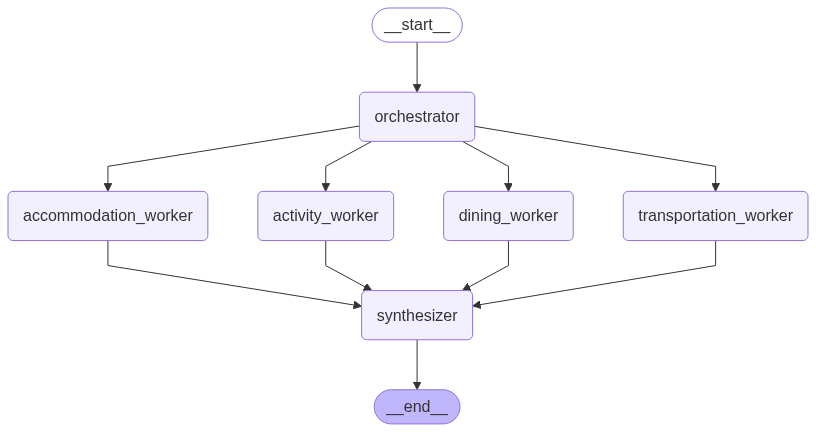

In [114]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        compiled_travel_workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Step 9. Testing and Validation

In [115]:
def test_travel_planner():
    """Test the orchestrator-workers travel planning system"""
    
    # Test different types of travel requests
    test_requests = [
        "Plan a 5-day romantic getaway to Paris for two people, budget $3000, interested in art and fine dining",
        
    ]
    
    for i, request in enumerate(test_requests, 1):
        print(f"\n{'='*60}")
        print(f"TEST {i}: {request}")
        print(f"{'='*60}")
        
        # Execute the workflow
        result = compiled_travel_workflow.invoke({
            "original_request": request
        })
        
        # Display results
        print(f"\nTask Breakdown ({result['task_breakdown']['total_tasks']} tasks):")
        for task in result['task_breakdown']['tasks']:
            print(f"  - {task['task_type']}: {task['task_description']}")
        
        # Show executed workers
        executed_workers = result['execution_metadata'].get('workers_executed', [])
        print(f"\nWorkers Executed: {', '.join(executed_workers)}")
        
        print(f"\nFinal Itinerary Preview:")
        print(result['final_itinerary'][:300] + "...")

In [116]:
# Run the test
if __name__ == "__main__":
    test_travel_planner()


TEST 1: Plan a 5-day romantic getaway to Paris for two people, budget $3000, interested in art and fine dining

Task Breakdown (5 tasks):
  - transportation_planning: Research and book suitable flights for two people to Paris within the provided budget.
  - accommodation_research: Find and book a romantic hotel or apartment accommodation for five days in Paris.
  - activity_planning: Research and create a list of art museums, galleries, and exhibitions to visit during the trip.
  - dining_recommendations: Identify and recommend fine dining restaurants and experiences in Paris based on the travelers' preferences.
  - transportation_planning: Plan transportation within Paris, including options like public transportation, walking tours, or private car services.

Workers Executed: dining_worker, activity_worker, transportation_worker, accommodation_worker

Final Itinerary Preview:
##  Your Romantic Parisian Getaway: A 5-Day Itinerary 

**Welcome to Paris, the City of Love!** This itinerar

In [119]:
orchestrate_travel_planning({'original_request': "Plan a 5-day romantic getaway to Paris for two people, budget $3000, interested in art and fine dining"})

{'task_breakdown': {'tasks': [{'task_id': 'hotel_booking',
    'task_type': 'accommodation_research',
    'task_description': 'Research and book suitable hotels/lodging for a romantic getaway.',
    'priority': 5,
    'required_context': ['budget', 'interests']},
   {'task_id': 'art_experiences',
    'task_type': 'activity_planning',
    'task_description': 'Identify and book reservations for art museums, galleries, and exhibitions.',
    'priority': 4,
    'required_context': ['interests']},
   {'task_id': 'fine_dining_recommendations',
    'task_type': 'dining_recommendations',
    'task_description': 'Research and recommend fine dining restaurants based on budget and preferences.',
    'priority': 4,
    'required_context': ['budget']},
   {'task_id': 'transportation_planning',
    'task_type': 'transportation_planning',
    'task_description': 'Plan transportation between locations in Paris (airport, hotels, attractions).',
    'priority': 3,
    'required_context': []},
   {'task_